In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from scipy.stats import norm
from DataHandling import *
from ModelClasses import *
import matplotlib.pyplot as plt
from IDPredictor import *

In [2]:
# Define number of hours as length of demand
N_Hours = hours_per_year

# Define number of generators as length of CapCost
N_Cap = len(CapCost)

# Define number of storage as length of StorCost
N_Stor = len(StorCost)

# Define number of scenarios as number of columns in ProdFacWind
N_Scen = scenarios_per_year * len(years)

# Define epsilon
epsilon = 5/6


BatteryCapacity = 100
BatterPower = 100


In [3]:
def extract_capacity_results(res, case_id,capacity_results, kpi_dict):
    # Tag for column name
    
        # Process generation
        capnew_df = res.CapNew[['Plant', 'CapNew[GW]']].copy()
        capnew_df.columns = ['Plant', 'Capacity']
        capnew_df['Case'] = case_id
        capacity_results.append(capnew_df)

        # Process storage
        capstor_df = res.CapStor[['Plant', 'CapStor[GWh]']].copy()
        capstor_df.columns = ['Plant', 'Capacity']
        capstor_df['Case'] = case_id
        capacity_results.append(capstor_df)


        # Extract values
        avg_res = res.RESShare['RES Share'].mean()
        avg_co2 = res.CO2Intensity['CO2 Intensity [tCO2/MWh]'].mean()
        obj_val = res.obj

        # Fill into dict
        kpi_dict['Average RES Share'][case_id] = avg_res
        kpi_dict['Average CO2 Intensity'][case_id] = avg_co2
        kpi_dict['Objective Value'][case_id] = obj_val

        return capacity_results, kpi_dict

In [4]:
SetofCases = ['ReferenceCase','HighFuel', 'NetZero','HighFuel_NetZero','Situation2024','PoliticalTurnaround']#,'HighFuel', 'NetZero','HighFuel_NetZero']#,#'SituationToday', 'ReferenceCase', 'NetZero', 'HighFuel'] #SetofCases = ['SituationToday', 'ReferenceCase', 'NetZero', 'HighFuel']
SetofDeltas = [0,0.8]

# Initialization
capacity_results = []
kpi_dict = {
    'Average RES Share': {},
    'Average CO2 Intensity': {},
    'Objective Value': {}
}

DA_ID_price_frames = {}      # {case_id: DataFrame}
capture_price_dict = {}      # {case_id: Series}
stddev_dict = {
    'StdDev_DA_Prices': {},
    'StdDev_ID_Prices': {}
}

for RunScenario in SetofCases:
    for delta in SetofDeltas:
        print(f'Running scenario: {RunScenario} with delta: {delta}')
        case_id = f'{RunScenario}_{delta}'

        # Load scenario data
        Demand, OpCost, CapOut, CO2Intensity, FixedOpex, StorExi, CapExi = get_scenario_data(RunScenario)
        BigM = delta * sum(Demand)

        ParametersObj = Parameters(epsilon, delta, N_Hours, N_Cap, N_Stor, N_Scen, BigM, BatteryCapacity, BatterPower)
        DataObj = InputData(CapCost, OpCost, TechInfo, StorCost, CapLim, CapExi, CapOut,
                            Demand, EtaCh, EtaDis, StorExi, Offwind_scenarios,
                            Onwind_scenarios, Solar_scenarios, StorLim, CO2Intensity,StorCost_DF,FixedOpex,StorOpex,BatteryEfficiency,MinLoad)

        # Run capacity model
        capacity_problem = CapacityProblem(ParametersObj, DataObj)
        res = capacity_problem.res

        # Extract capacity arrays
        ResultsCapacity = np.array(res.CapNew['CapNew[GW]'])
        ResultsStorage = np.array(res.CapStor['CapStor[GWh]'])

        # Collect capacity results & KPIs
        extract_capacity_results(res, case_id, capacity_results, kpi_dict)

        # Run day-ahead model
        DA_problem = DayAheadProblem(ParametersObj, DataObj, ResultsCapacity, ResultsStorage, IDForecaster)
        res_DA = DA_problem.res
        DayAheadPrices = res_DA.DA_Prices
        IntraDayPrices = res_DA.IntraDay_PricesArray
        DayAheadPricesTransformed = DayAheadPrices.to_numpy()

        # ---------------------
        # 1. Save DA/ID prices
        

        columns = []
        price_columns = []

        for s in range(ParametersObj.N_Scen):
            DA_col = f"Scenario_{s}_DA"
            ID_col = f"Scenario_{s}_ID"
            columns.extend([DA_col, ID_col])

            DA_prices = res_DA.DA_Prices.iloc[:, s].values
            ID_prices = res_DA.IntraDay_PricesArray[:, s]

            price_columns.append(DA_prices)
            price_columns.append(ID_prices)

        # Stack all DA/ID columns horizontally
        data = np.column_stack(price_columns)

        # Build DataFrame with Hour index
        df_prices = pd.DataFrame(data, columns=columns)
        df_prices['Hour'] = range(ParametersObj.N_Hours)
        DA_ID_price_frames[case_id] = df_prices.set_index('Hour')

        # ---------------------
        # 2. Save capture prices
        tech_means = res_DA.CapturePrices.astype(float).mean(axis=1)
        capture_price_dict[case_id] = tech_means

        # ---------------------
        # 3. Save std deviations
        std_da = res_DA.DA_Prices.std(axis=1).mean()
        std_id = pd.DataFrame(res_DA.IntraDay_PricesArray).std(axis=1).mean()
        stddev_dict['StdDev_DA_Prices'][case_id] = std_da
        stddev_dict['StdDev_ID_Prices'][case_id] = std_id



        BatteryOpt = BatteryOptimization(ParametersObj, DataObj, DayAheadPricesTransformed, IntraDayPrices)
        res_Batt = BatteryOpt.res

        # 5. Get the financial summary and add column average as a new row
        financial_df = res_Batt.FinancialSummary.copy()
        average_row = financial_df.mean(numeric_only=True)
        average_row.name = 'Average'
        financial_df = pd.concat([financial_df, pd.DataFrame([average_row])])

        # 6. Store as named DataFrame
        safe_case_id = case_id.replace(".", "_")
        globals()[f"{safe_case_id}_BatterySummary"] = financial_df  

# ---------------------
# FINAL DATAFRAMES

# Pivot: capacity results
cap_df = pd.concat(capacity_results, ignore_index=True)
FinalCapacityResults = cap_df.pivot(index='Plant', columns='Case', values='Capacity').fillna(0)

# KPIs
kpi_df = pd.DataFrame.from_dict(kpi_dict, orient='index')
kpi_df = kpi_df[sorted(kpi_df.columns)]

# Capture Prices
capture_price_df = pd.DataFrame(capture_price_dict)
capture_price_df = capture_price_df[sorted(capture_price_df.columns)]

# Std Devs
stddev_kpi_df = pd.DataFrame.from_dict(stddev_dict, orient='index')
stddev_kpi_df = stddev_kpi_df[sorted(stddev_kpi_df.columns)]

# Automatically assign each case DataFrame to a variable
for case_id, df in DA_ID_price_frames.items():
    safe_case_id = case_id.replace(".", "_")
    globals()[safe_case_id] = df

     



Running scenario: ReferenceCase with delta: 0
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-14
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 876003 rows, 630738 columns and 2835835 nonzeros
Model fingerprint: 0x01ed8afb
Variable types: 630734 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [2e+03, 1e+09]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-04, 5e+03]
Presolve removed 282722 rows and 72463 columns
Presolve time: 4.30s
Presolved: 593281 rows, 558275 columns, 1779863 nonzeros
Variable types: 558275 continuous, 0 integer (0 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barr

### Create Plot for existing capacity

NameError: name 'CapExidf' is not defined

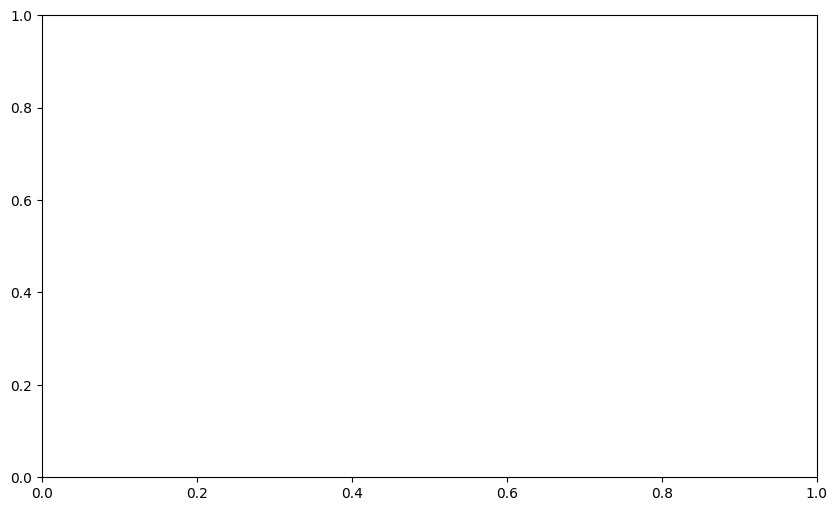

In [5]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary axis: CapExidf
bars1 = ax1.bar(CapExidf['Technology'], CapExidf['Capacity [GW]'], 
                label='Existing Generation Capacity', alpha=0.7)
ax1.set_ylabel('Capacity [GW]', fontsize=14)
ax1.tick_params(axis='x', labelrotation=90, labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

# Add labels for CapExidf bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=11)

# Secondary axis: StorExidf
ax2 = ax1.twinx()
bars2 = ax2.bar(StorExidf['Technology'], StorExidf['Capacity [GWh]'],
                label='Existing Storage Capacity', alpha=0.7, color='orange', width=0.4)
ax2.set_ylabel('Capacity [GWh]', fontsize=14)
ax2.tick_params(axis='y', labelsize=12)

# Adjust x positions and add labels
for bar in bars2:
    bar.set_x(bar.get_x() + 0.2)
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=11)

# Adjust layout and legend
fig.tight_layout()
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=12)

plt.show()


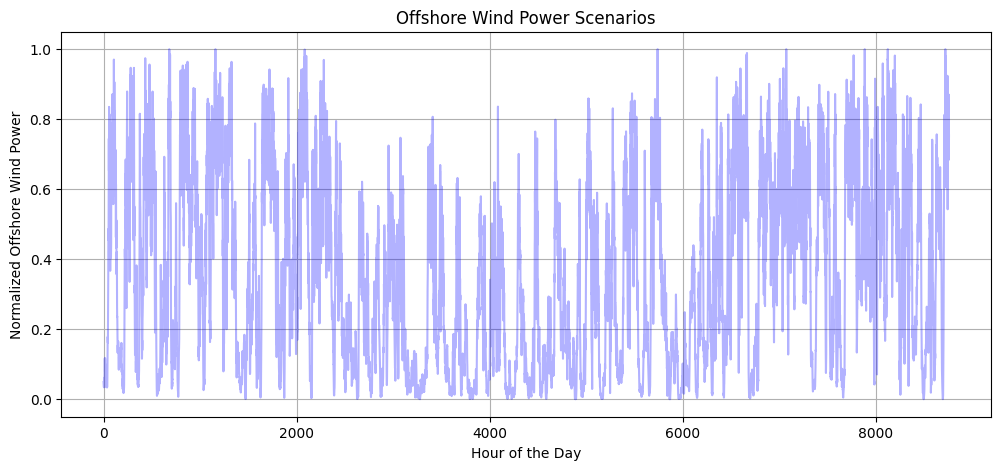

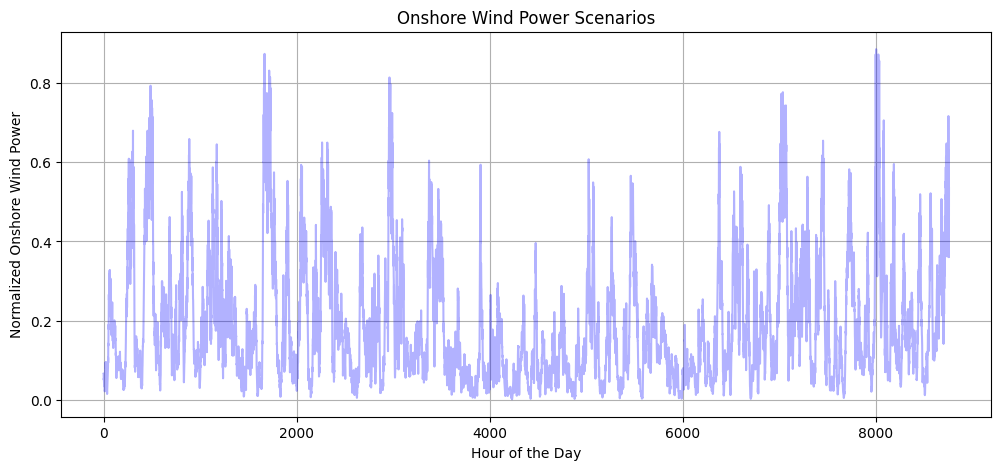

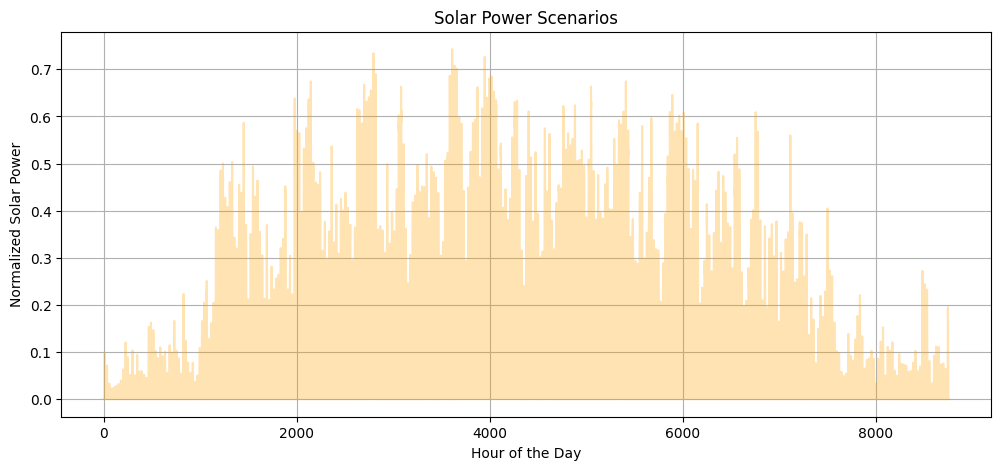

In [ ]:


# Plot offshore Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen): 
    plt.plot(range(N_Hours), Offwind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Offshore Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Offshore Wind Power")
plt.grid(True)
plt.show()

# Plot onshore Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  
    plt.plot(range(N_Hours), Onwind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Onshore Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Onshore Wind Power")
plt.grid(True)
plt.show()

# Plot Solar Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen): 
    plt.plot(range(N_Hours), Solar_scenarios[:, scenario], alpha=0.3, color='orange')
plt.title("Solar Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Solar Power")
plt.grid(True)
plt.show()

### Plot demand 17.01

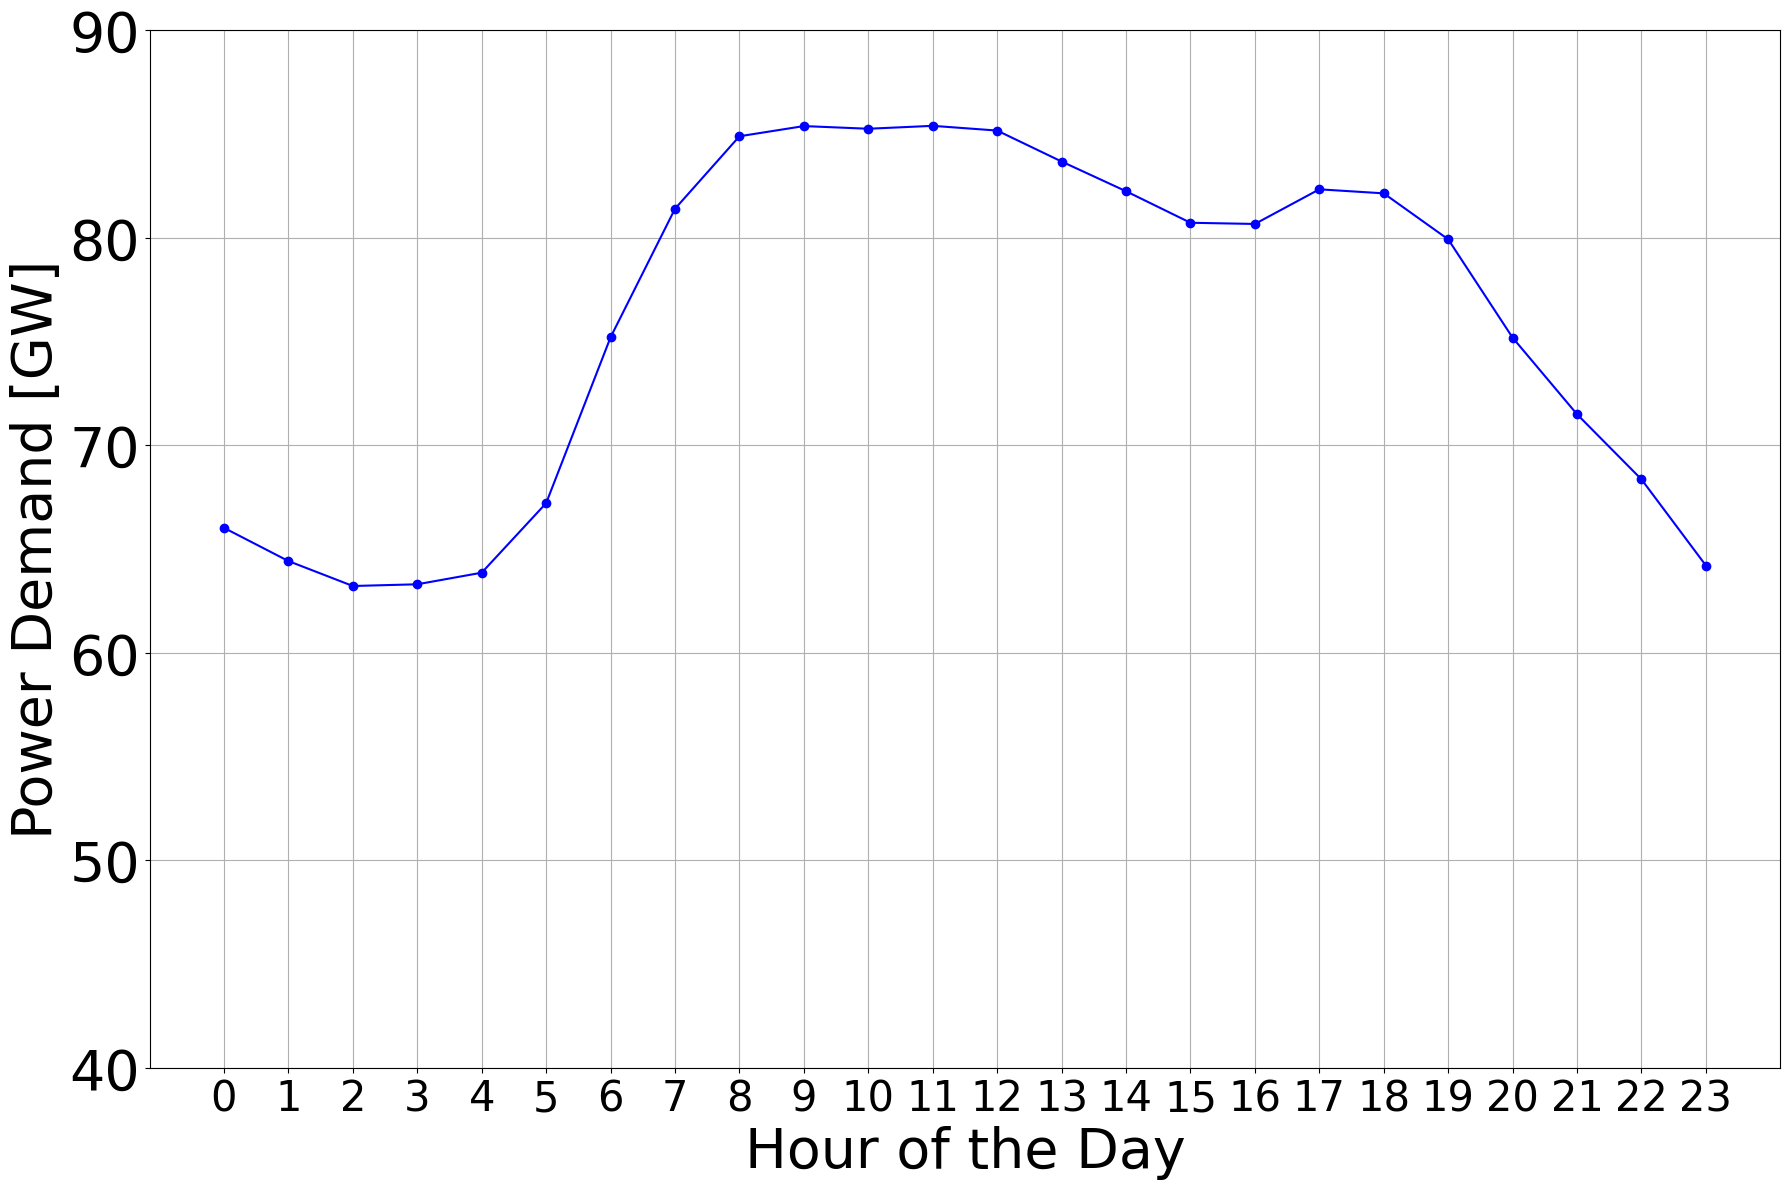

In [ ]:
# Choose a day to plot (e.g., day 50 of the year)
day_index = 16  # 0-based index (0 = Jan 1)
start_hour = day_index * 24
end_hour = start_hour + 24

# Extract 24-hour slice
daily_demand = Demand[start_hour:end_hour]

# Plot
plt.figure(figsize=(18,12))
plt.plot(range(24), daily_demand, color='blue', marker='o', label=f'Day {day_index + 1}')

#plt.title(f"Electricity Demand for Day {day_index + 1}")
plt.xlabel("Hour of the Day", fontsize=40)
plt.ylabel("Power Demand [GW]", fontsize=40)
plt.xticks(range(24), fontsize=30)
plt.yticks(fontsize=40)
plt.grid(True)
#plt.legend()
plt.ylim(40, 90)

plt.tight_layout()
plt.show()

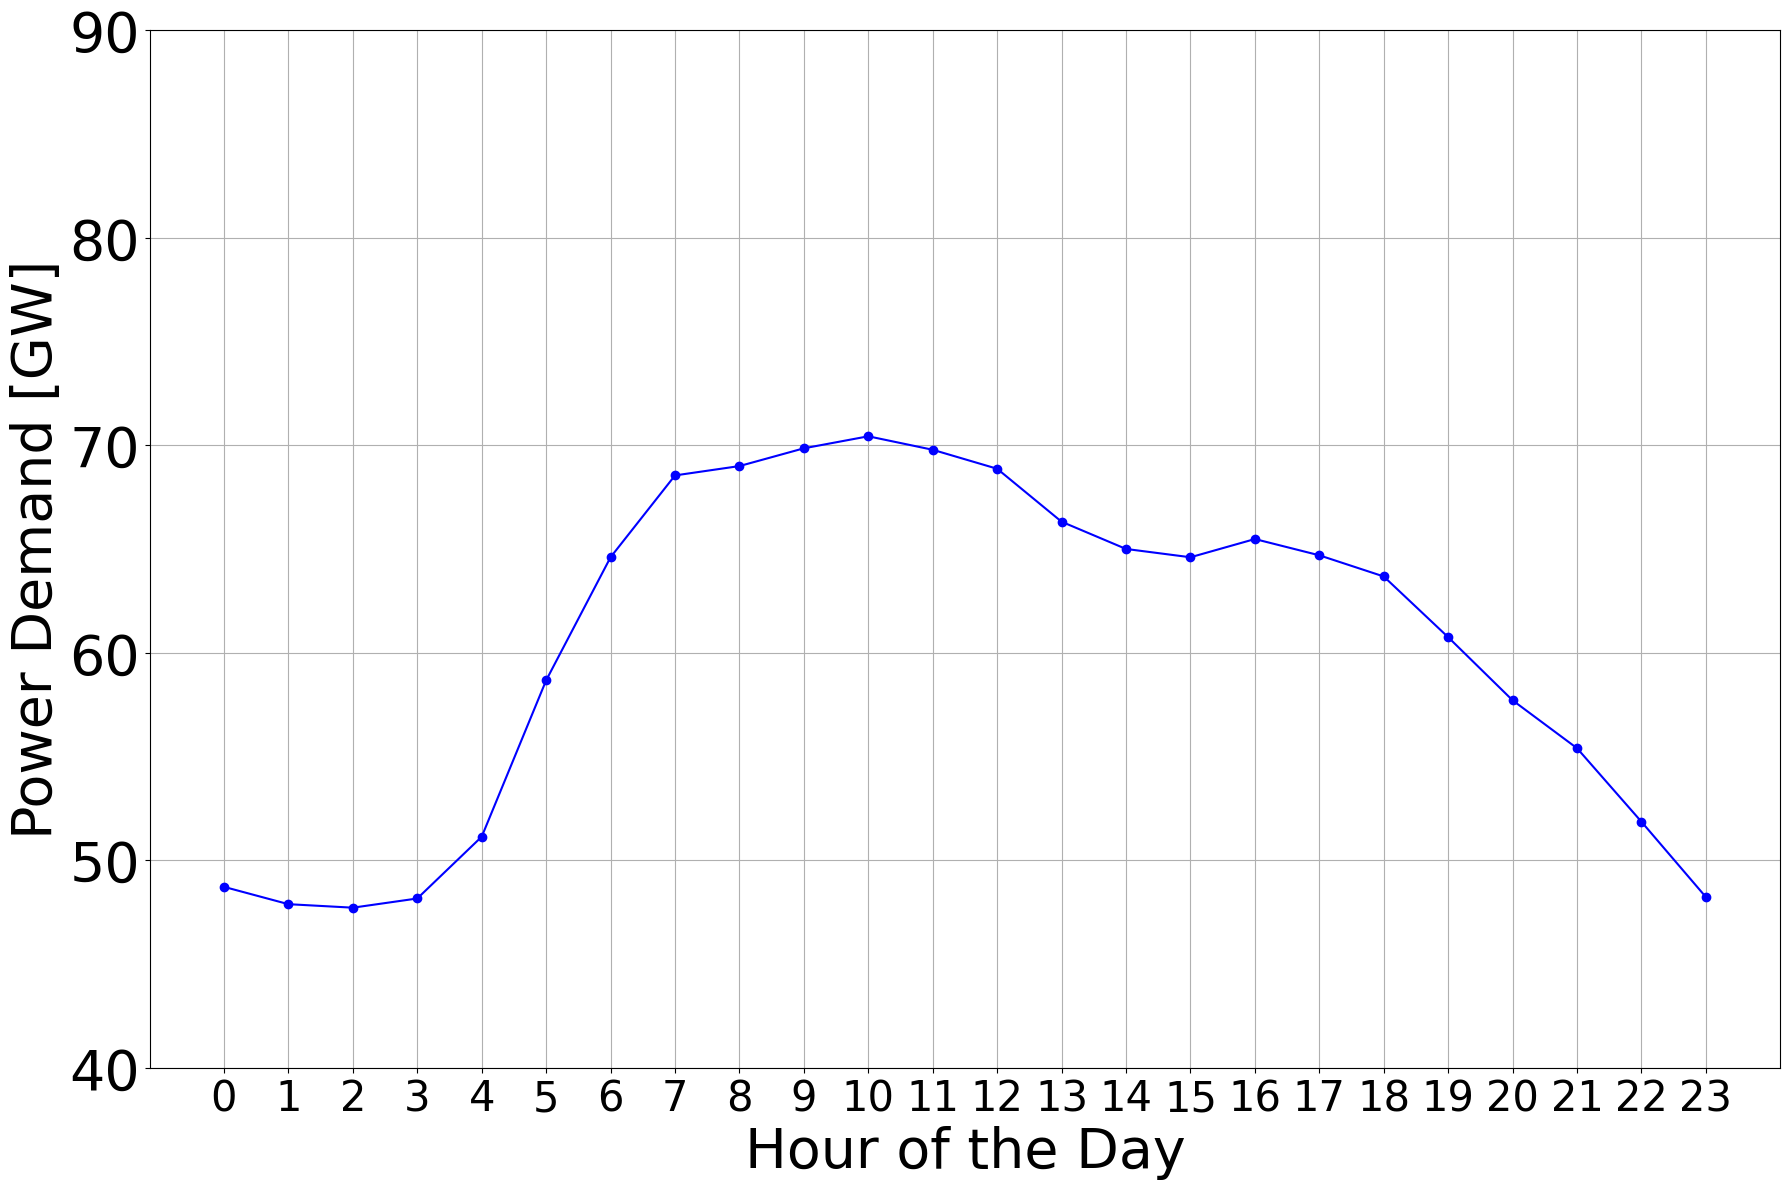

In [ ]:
# Choose a day to plot (e.g., day 50 of the year)
day_index = 178  # 0-based index (0 = Jan 1)
start_hour = day_index * 24
end_hour = start_hour + 24

# Extract 24-hour slice
daily_demand = Demand[start_hour:end_hour]

# Plot
plt.figure(figsize=(18,12))
plt.plot(range(24), daily_demand, color='blue', marker='o', label=f'Day {day_index + 1}')

#plt.title(f"Electricity Demand for Day {day_index + 1}")
plt.xlabel("Hour of the Day", fontsize=40)
plt.ylabel("Power Demand [GW]", fontsize=40)
plt.xticks(range(24), fontsize=30)
plt.yticks(fontsize=40)
plt.grid(True)
#plt.legend()
plt.ylim(40, 90)

plt.tight_layout()
plt.show()

## Plotting a summer day (29.06.)

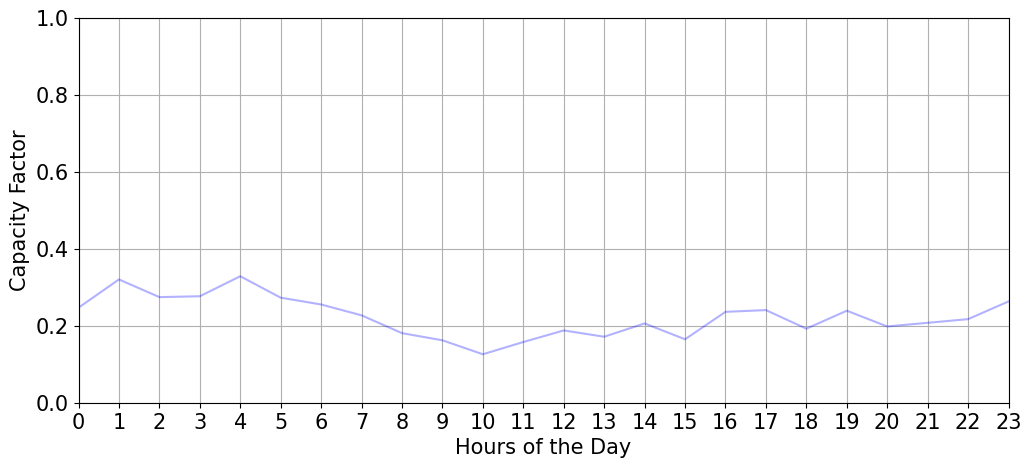

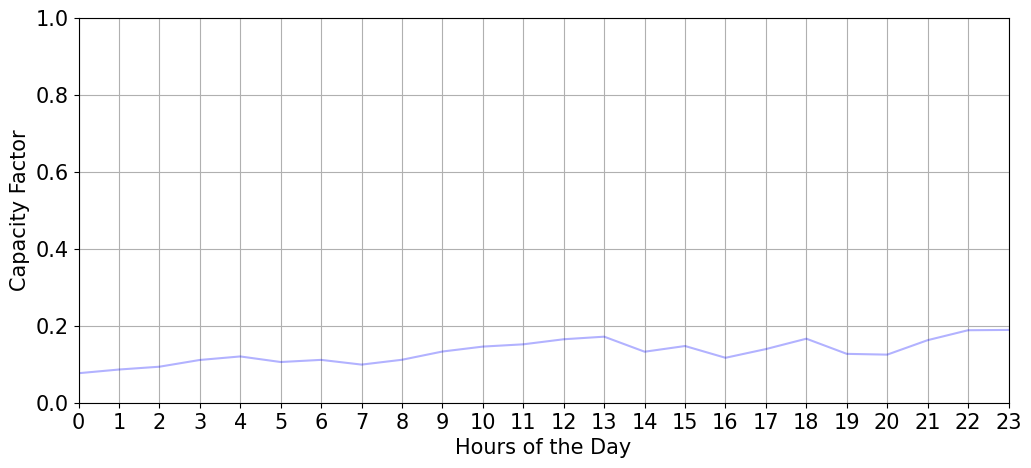

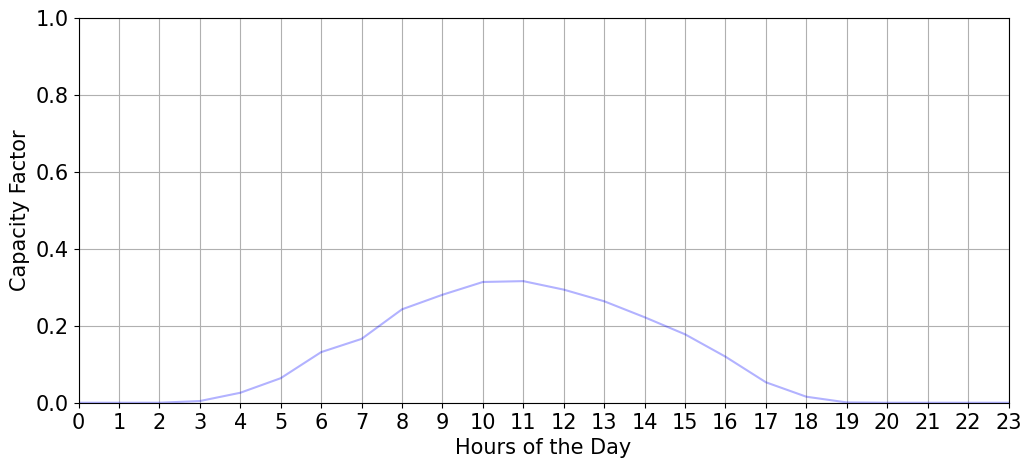

In [ ]:
#Plot one day of offshore wind scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(24), Offwind_scenarios[1+24*180:25+24*180, scenario], alpha=0.3, color='blue')
#plt.title("Offshore Wind Power Scenarios for One Day")
plt.xlabel("Hours of the Day", fontsize=15)
plt.ylabel("Capacity Factor", fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.grid(True)
plt.xlim(0, 23)  # Limit x-axis to 24 hours
plt.xticks(range(24))  # Set x-ticks to show each hour
plt.ylim(0, 1)
plt.show()


#Plot one day of onshore wind scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(24), Onwind_scenarios[1+24*180:25+24*180, scenario], alpha=0.3, color='blue')
#plt.title("Onshore Wind Power Scenarios for One Day")
plt.xlabel("Hours of the Day", fontsize=15)
plt.ylabel("Capacity Factor", fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.grid(True)
plt.xlim(0, 23)  # Limit x-axis to 24 hours
plt.xticks(range(24))  # Set x-ticks to show each hour
plt.ylim(0, 1)
plt.show()

#Plot one day of solar wind scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(24), Solar_scenarios[1+24*180:25+24*180, scenario], alpha=0.3, color='blue')
#plt.title("Solar Power Scenarios for One Day")
plt.xlabel("Hours of the Day", fontsize=15)
plt.ylabel("Capacity Factor", fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.grid(True)
plt.xlim(0, 23)  # Limit x-axis to 24 hours
plt.xticks(range(24))  # Set x-ticks to show each hour
plt.ylim(0, 1)
plt.show()

## Plotting a winter day (01.01)

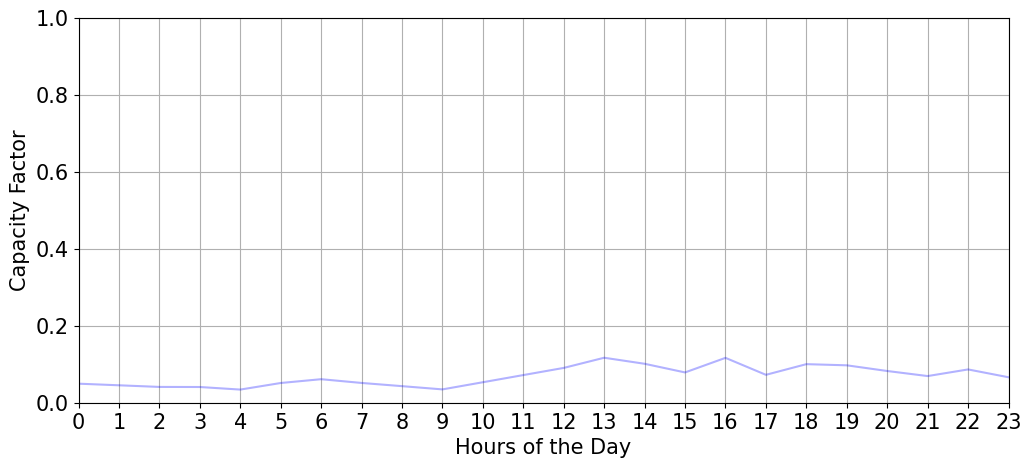

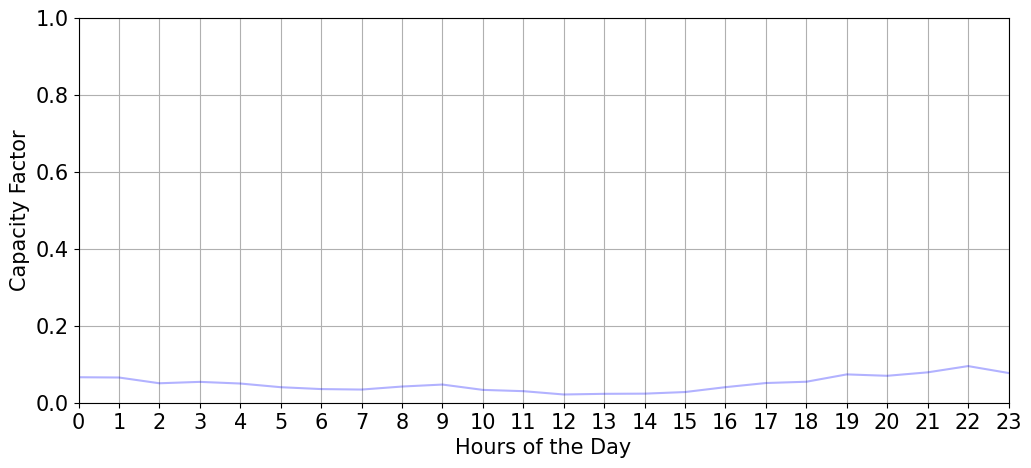

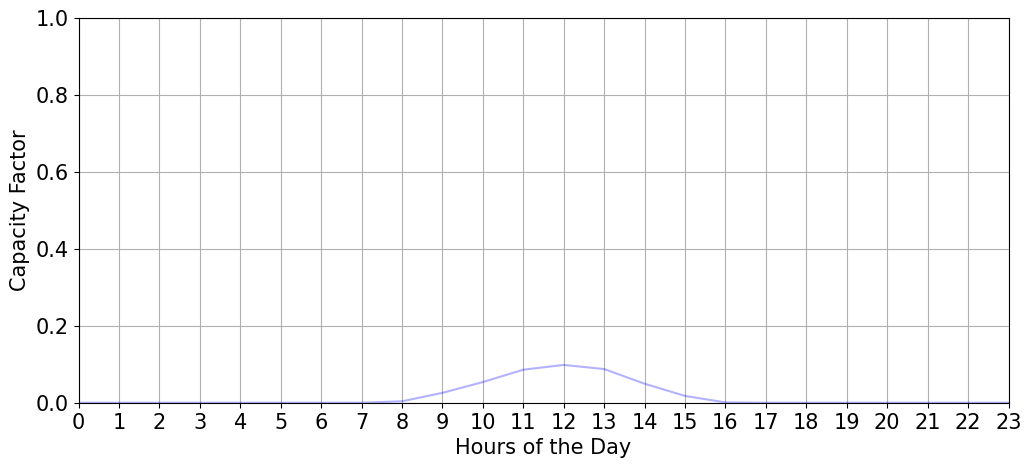

In [ ]:
#Plot one day of offshore wind scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(24), Offwind_scenarios[0:24, scenario], alpha=0.3, color='blue')
#plt.title("Offshore Wind Power Scenarios for One Day")
plt.xlabel("Hours of the Day", fontsize=15)
plt.ylabel("Capacity Factor", fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.grid(True)
plt.xlim(0, 23)  # Limit x-axis to 24 hours
plt.xticks(range(24))  # Set x-ticks to show each hour
plt.ylim(0, 1)
plt.show()


#Plot one day of onshore wind scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(24), Onwind_scenarios[0:24, scenario], alpha=0.3, color='blue')
#plt.title("Onshore Wind Power Scenarios for One Day")
plt.xlabel("Hours of the Day", fontsize=15)
plt.ylabel("Capacity Factor", fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.grid(True)
plt.xlim(0, 23)  # Limit x-axis to 24 hours
plt.xticks(range(24))  # Set x-ticks to show each hour
plt.ylim(0, 1)
plt.show()

#Plot one day of solar wind scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(24), Solar_scenarios[0:24, scenario], alpha=0.3, color='blue')
#plt.title("Solar Power Scenarios for One Day")
plt.xlabel("Hours of the Day", fontsize=15)
plt.ylabel("Capacity Factor", fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.grid(True)
plt.xlim(0, 23)  # Limit x-axis to 24 hours
plt.xticks(range(24))  # Set x-ticks to show each hour
plt.ylim(0, 1)
plt.show()

In [6]:
# Calculate the average capacity factor acrss all scenarios and hours
# for each renewable energy source
avg_offwind = np.mean(Offwind_scenarios)
avg_onwind = np.mean(Onwind_scenarios)
avg_solar = np.mean(Solar_scenarios)
print(f"Average Offshore Wind Capacity Factor: {avg_offwind:.4f}")
print(f"Average Onshore Wind Capacity Factor: {avg_onwind:.4f}")
print(f"Average Solar Capacity Factor: {avg_solar:.4f}")

Average Offshore Wind Capacity Factor: 0.3473
Average Onshore Wind Capacity Factor: 0.2117
Average Solar Capacity Factor: 0.1024


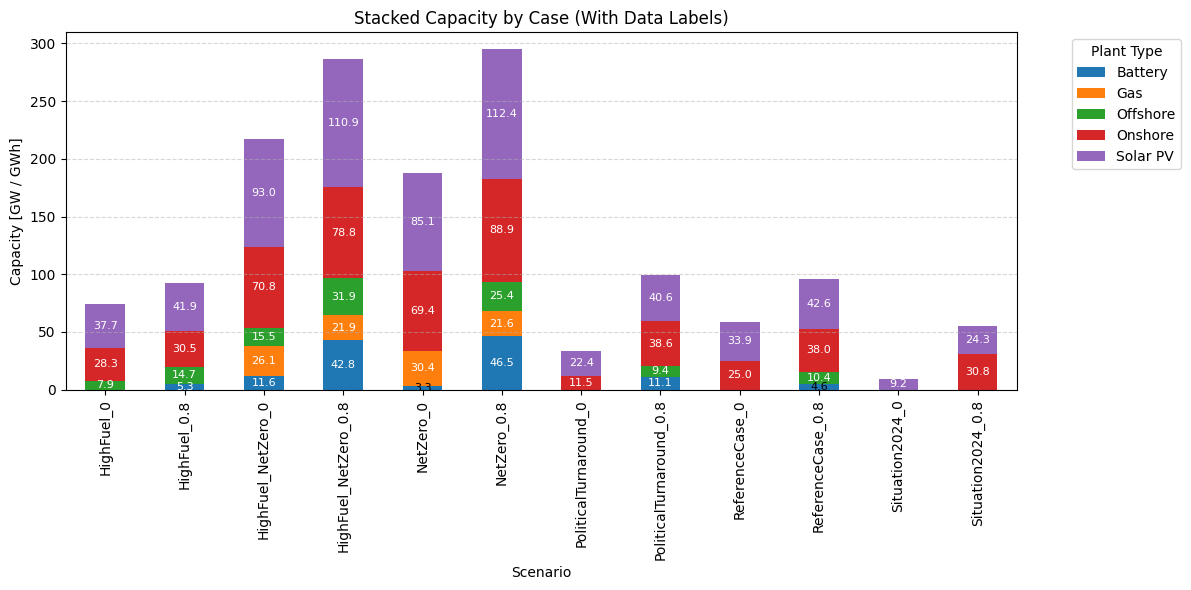

In [7]:
import matplotlib.pyplot as plt

# Filter non-zero plants
nonzero_plants = FinalCapacityResults[FinalCapacityResults.sum(axis=1) != 0]
data = nonzero_plants.T  # Transpose for plotting

# Create stacked bar plot
ax = data.plot(kind='bar', stacked=True, figsize=(12, 6))

# Add data labels
for i, case in enumerate(data.index):  # For each scenario (bar)
    cumulative = 0
    for plant in data.columns:  # For each plant type
        value = data.loc[case, plant]
        if value > 0:
            ax.text(
                i, cumulative + value / 2,               # x = bar, y = middle of the segment
                f'{value:.1f}',                          # Label text
                ha='center', va='center', fontsize=8,
                color='white' if value > 5 else 'black'  # Light-on-dark if large enough
            )
            cumulative += value

# Style the plot
plt.title('Stacked Capacity by Case (With Data Labels)')
plt.xlabel('Scenario')
plt.ylabel('Capacity [GW / GWh]')
plt.legend(title='Plant Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.show()


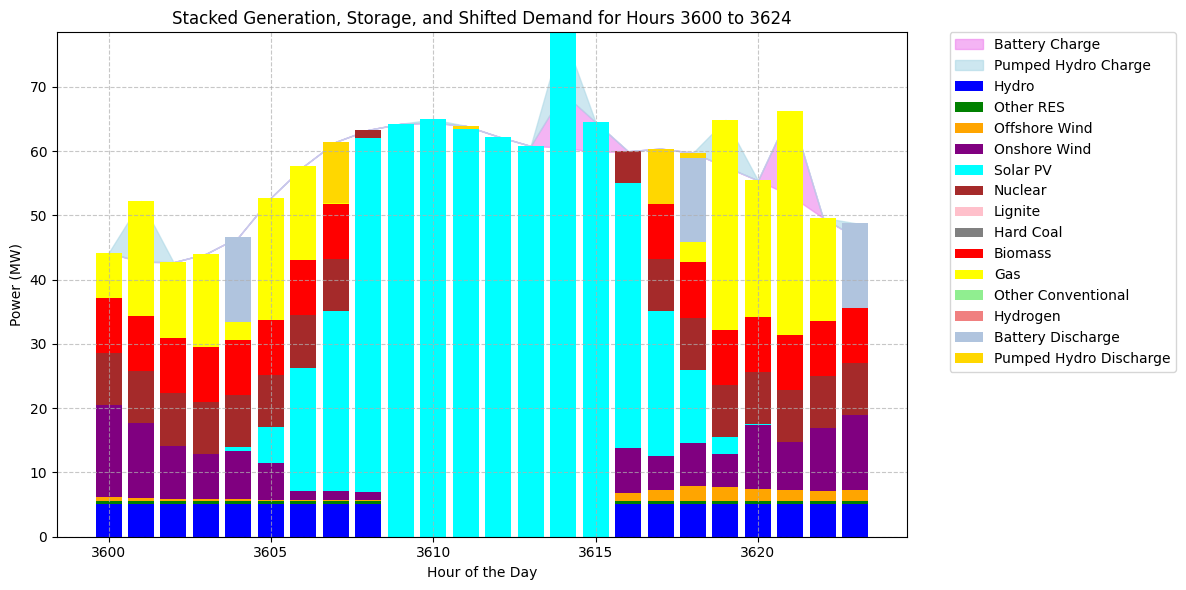

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Select the hours to be plotted
start_hour = 0+24*150
end_hour = 24+24*150
one_day_data = res_DA.DA_EGen_Scenarios['DA_Scenario_0'].query(f"Hour >= {start_hour} & Hour < {end_hour}")

# Prepare the data
hours = one_day_data['Hour']

# Generation and discharge sources
generation_sources = {
    'Hydro': one_day_data['Hydro'],
    'Other RES': one_day_data['Other RES'],
    'Offshore Wind': one_day_data['Offshore'],
    'Onshore Wind': one_day_data['Onshore'],
    'Solar PV': one_day_data['Solar PV'],
    'Nuclear': one_day_data['Nuclear'],
    'Lignite': one_day_data['Lignite'],
    'Hard Coal': one_day_data['Hard Coal'],
    'Biomass': one_day_data['Biomass'],
    'Gas': one_day_data['Gas'],
    'Other Conventional': one_day_data['Other Conventional'],
    'Hydrogen': one_day_data['Hydrogren'],
    'Battery Discharge': one_day_data['Battery_Discharge'],
    'Pumped Hydro Discharge': one_day_data['PumpedHydro_Discharge']
}

# Colors for generation types
gen_colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'brown', 'pink', 
              'gray', 'red', 'yellow', 'lightgreen', 'lightcoral', 'lightsteelblue', 'gold']



plt.figure(figsize=(12, 6))

# Check if there is any battery or hydro charge
if (one_day_data['Battery_Charge'].sum() == 0) and (one_day_data['PumpedHydro_Charge'].sum() == 0):
    # If there is no charge, show the original demand line
    plt.plot(one_day_data['Hour'], one_day_data['Demand'], label='Demand', color='red', linestyle='--')
else:
    # If there is charging, the demand line is hidden (visually replaced by stacked charge)
    plt.fill_between(one_day_data['Hour'],
                     one_day_data['Demand'],
                     one_day_data['Demand'] + one_day_data['Battery_Charge'],
                     label='Battery Charge', color='violet', alpha=0.6)

    plt.fill_between(one_day_data['Hour'],
                     one_day_data['Demand'] + one_day_data['Battery_Charge'],
                     one_day_data['Demand'] + one_day_data['Battery_Charge'] + one_day_data['PumpedHydro_Charge'],
                     label='Pumped Hydro Charge', color='lightblue', alpha=0.6)

# Plot the generation sources as a stacked bar chart
bottom_stack = np.zeros(len(hours))

for idx, (label, data) in enumerate(generation_sources.items()):
    plt.bar(hours, data, bottom=bottom_stack, label=label, color=gen_colors[idx])
    bottom_stack += data  # Update the bottom for the next layer

# Final touches
plt.title(f"Stacked Generation, Storage, and Shifted Demand for Hours {start_hour} to {end_hour}")
plt.xlabel("Hour of the Day")
plt.ylabel("Power (MW)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


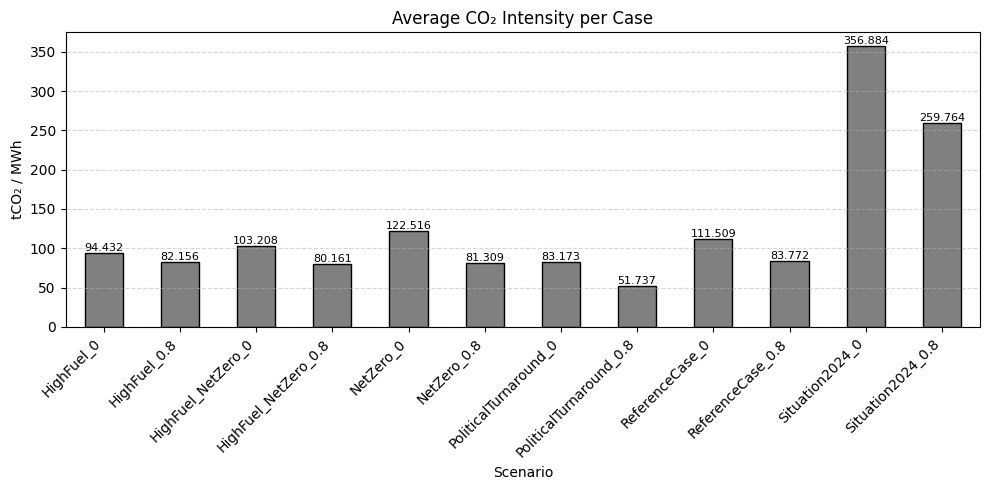

In [9]:
import matplotlib.pyplot as plt

# Extract the CO2 intensity row
co2_series = kpi_df.loc['Average CO2 Intensity']

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 5))
co2_series.plot(kind='bar', color='gray', edgecolor='black', ax=ax)

# Add data labels
for i, (label, value) in enumerate(co2_series.items()):
    ax.text(i, value + 0.002, f'{value:.3f}', ha='center', va='bottom', fontsize=8)

# Style
plt.title('Average CO₂ Intensity per Case')
plt.ylabel('tCO₂ / MWh')
plt.xlabel('Scenario')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


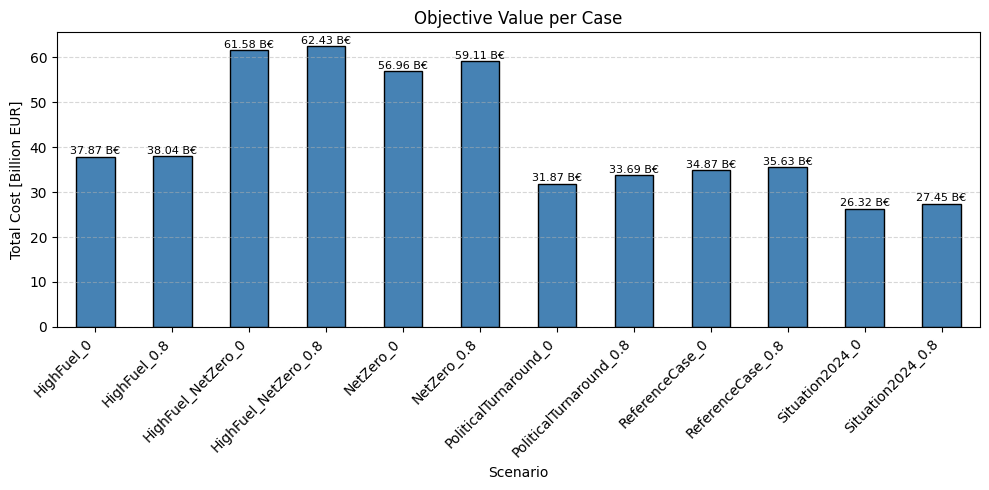

In [10]:
import matplotlib.pyplot as plt

# Extract the objective value row
obj_series = kpi_df.loc['Objective Value']

# Convert to billions if needed for better readability
obj_series_billion = obj_series / 1e9

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 5))
obj_series_billion.plot(kind='bar', color='steelblue', edgecolor='black', ax=ax)

# Add data labels
for i, (label, value) in enumerate(obj_series_billion.items()):
    ax.text(i, value + 0.05, f'{value:.2f} B€', ha='center', va='bottom', fontsize=8)

# Style
plt.title('Objective Value per Case')
plt.ylabel('Total Cost [Billion EUR]')
plt.xlabel('Scenario')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


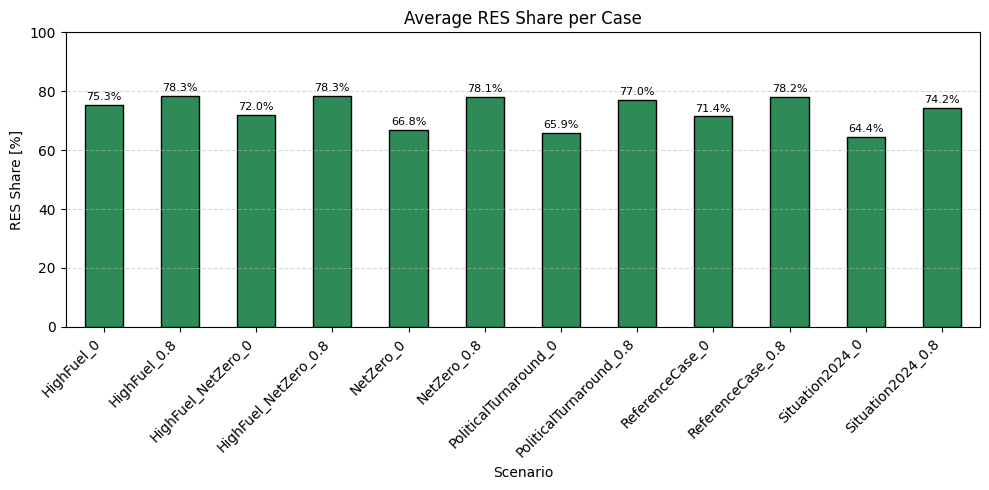

In [11]:
import matplotlib.pyplot as plt

# Extract RES share row
res_share_series = kpi_df.loc['Average RES Share'] * 100  # convert to percentage

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 5))
res_share_series.plot(kind='bar', color='seagreen', edgecolor='black', ax=ax)

# Add data labels
for i, (label, value) in enumerate(res_share_series.items()):
    ax.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', fontsize=8)

# Style
plt.title('Average RES Share per Case')
plt.ylabel('RES Share [%]')
plt.xlabel('Scenario')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(res_share_series.max() + 10, 100))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


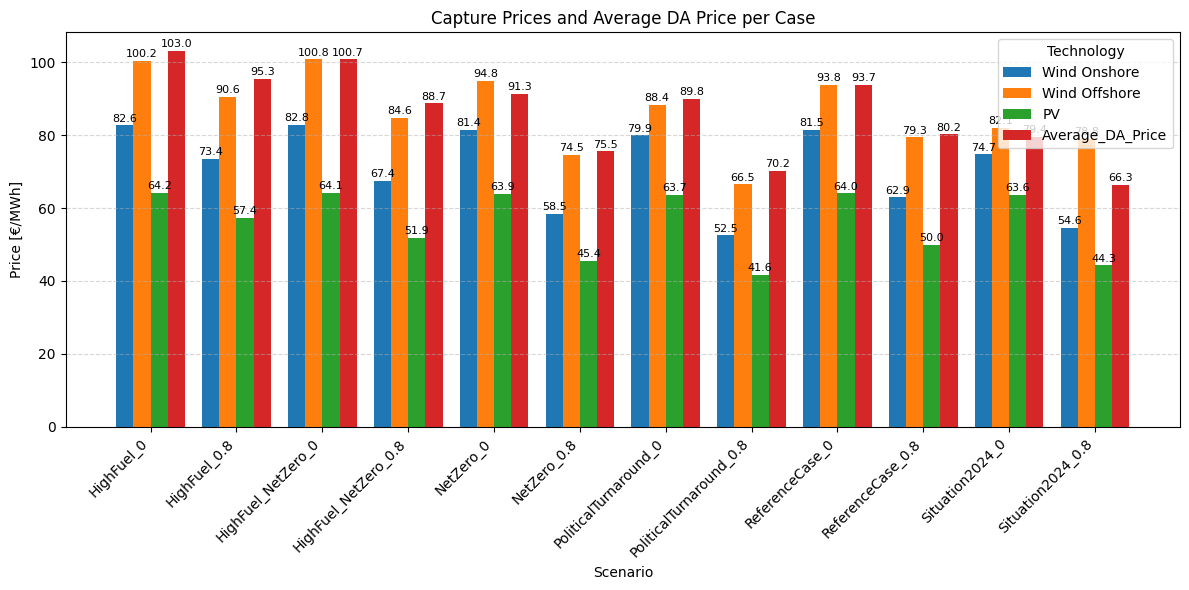

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Technologies to include
selected_techs = ['Wind Onshore', 'Wind Offshore', 'PV', 'Average_DA_Price']

# Filter the DataFrame
plot_df = capture_price_df.loc[selected_techs]

# Transpose for grouped plotting
plot_df = plot_df.T  # Rows: cases, Columns: techs

# Plot setup
cases = plot_df.index
techs = plot_df.columns
x = np.arange(len(cases))  # x locations
width = 0.2  # width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each technology as a group with data labels
for i, tech in enumerate(techs):
    bars = ax.bar(x + i * width, plot_df[tech], width=width, label=tech)

    # Add data labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.5,
                f'{height:.1f}',
                ha='center', va='bottom',
                fontsize=8
            )

# Styling
ax.set_title('Capture Prices and Average DA Price per Case')
ax.set_xlabel('Scenario')
ax.set_ylabel('Price [€/MWh]')
ax.set_xticks(x + width * (len(techs) - 1) / 2)
ax.set_xticklabels(cases, rotation=45, ha='right')
ax.legend(title='Technology')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


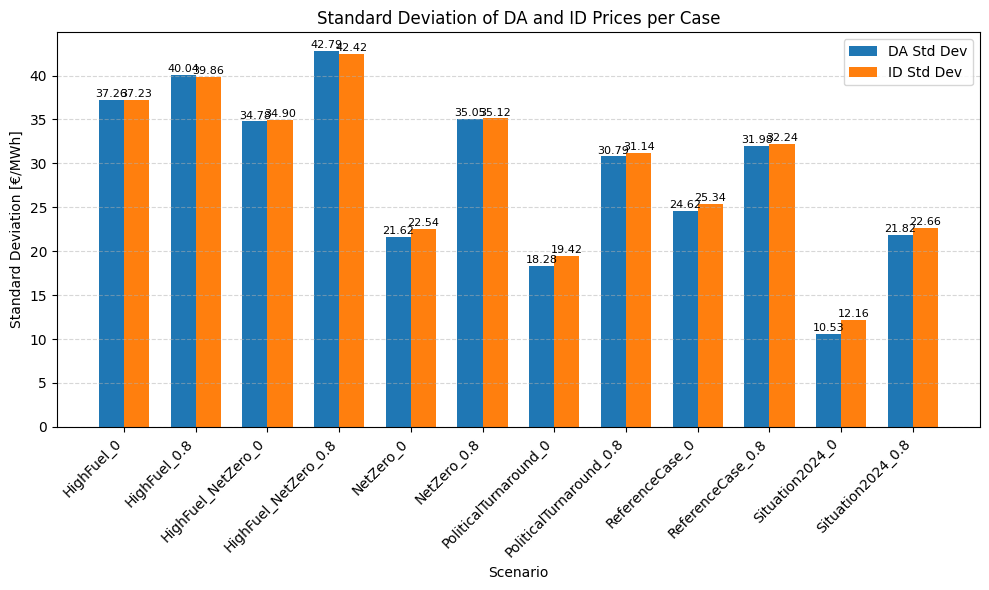

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Transpose for plotting
plot_df = stddev_kpi_df.T  # Rows: cases, Columns: price types

# Setup
x = np.arange(len(plot_df.index))  # case positions
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each bar
bar1 = ax.bar(x - width/2, plot_df['StdDev_DA_Prices'], width, label='DA Std Dev')
bar2 = ax.bar(x + width/2, plot_df['StdDev_ID_Prices'], width, label='ID Std Dev')

# Add data labels
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.1,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=8
        )

# Style
ax.set_title('Standard Deviation of DA and ID Prices per Case')
ax.set_xlabel('Scenario')
ax.set_ylabel('Standard Deviation [€/MWh]')
ax.set_xticks(x)
ax.set_xticklabels(plot_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


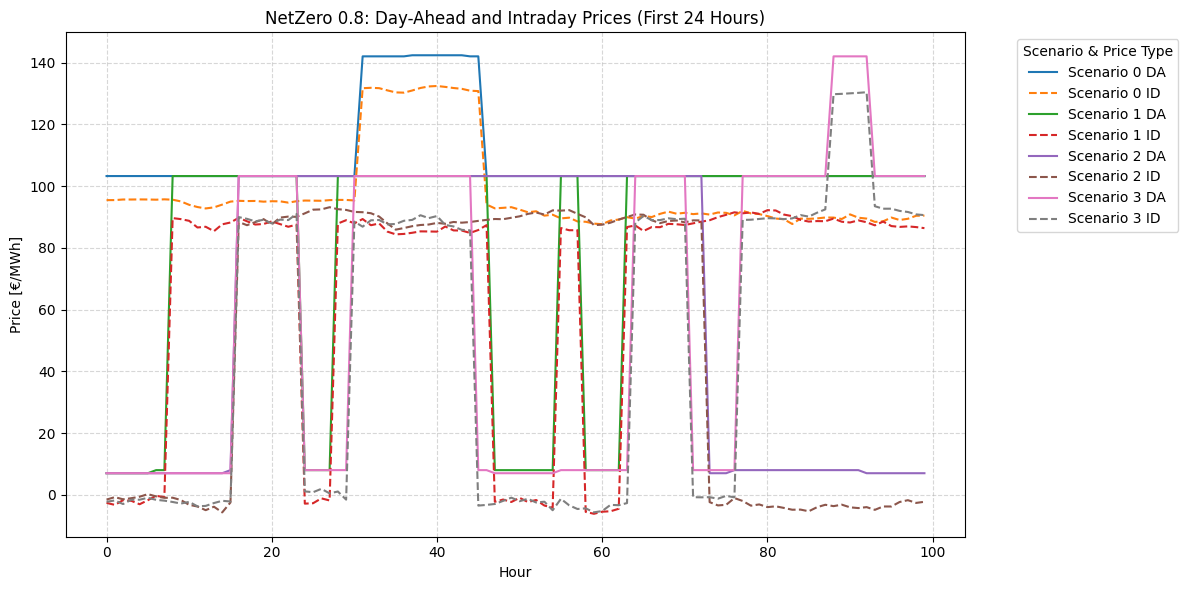

In [ ]:
df_prices = DA_ID_price_frames['ReferenceCase_0']  # <-- exact string
subset = df_prices.iloc[0:100]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for col in subset.columns:
    linestyle = '-' if 'DA' in col else '--'
    plt.plot(subset.index, subset[col], linestyle=linestyle, label=col.replace('_', ' '))

plt.title('NetZero 0.8: Day-Ahead and Intraday Prices (First 24 Hours)')
plt.xlabel('Hour')
plt.ylabel('Price [€/MWh]')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Scenario & Price Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


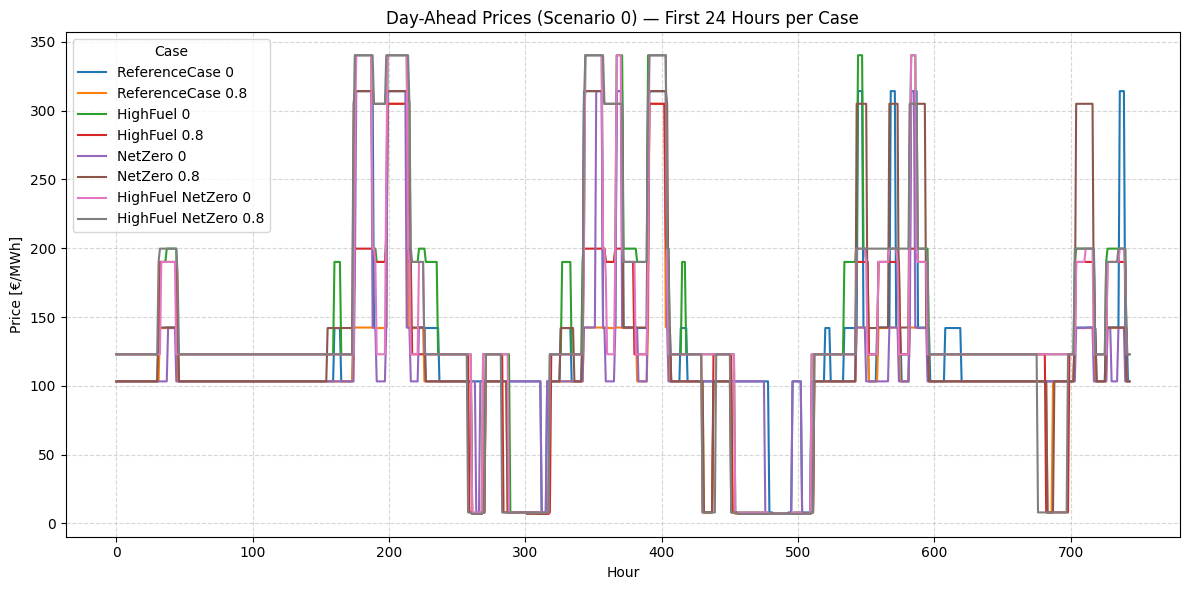

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Loop through all cases
for case_id, df in DA_ID_price_frames.items():
    if 'Scenario_0_DA' in df.columns:
        subset = df['Scenario_0_DA'].iloc[:24*31]
        label = case_id.replace('_', ' ')
        plt.plot(subset.index, subset.values, label=label)

# Style
plt.title('Day-Ahead Prices (Scenario 0) — First 24 Hours per Case')
plt.xlabel('Hour')
plt.ylabel('Price [€/MWh]')
plt.legend(title='Case')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


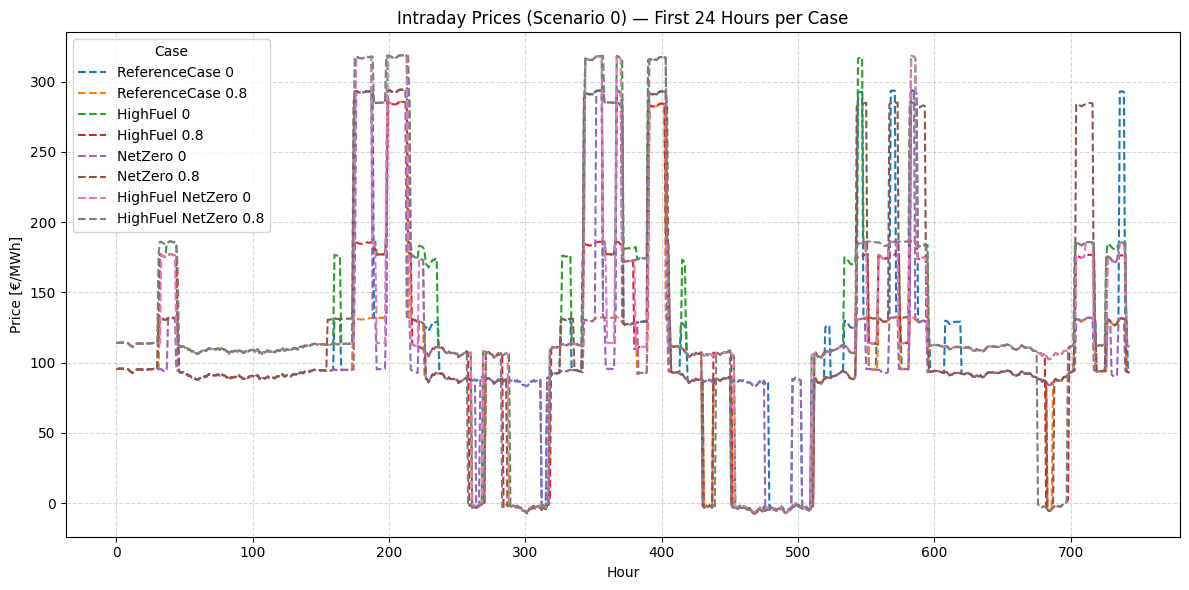

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Loop through all cases
for case_id, df in DA_ID_price_frames.items():
    col = 'Scenario_0_ID'
    if col in df.columns:
        subset = df[col].iloc[:24*31]
        label = case_id.replace('_', ' ')
        plt.plot(subset.index, subset.values, linestyle='--', label=label)

# Style
plt.title('Intraday Prices (Scenario 0) — First 24 Hours per Case')
plt.xlabel('Hour')
plt.ylabel('Price [€/MWh]')
plt.legend(title='Case')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


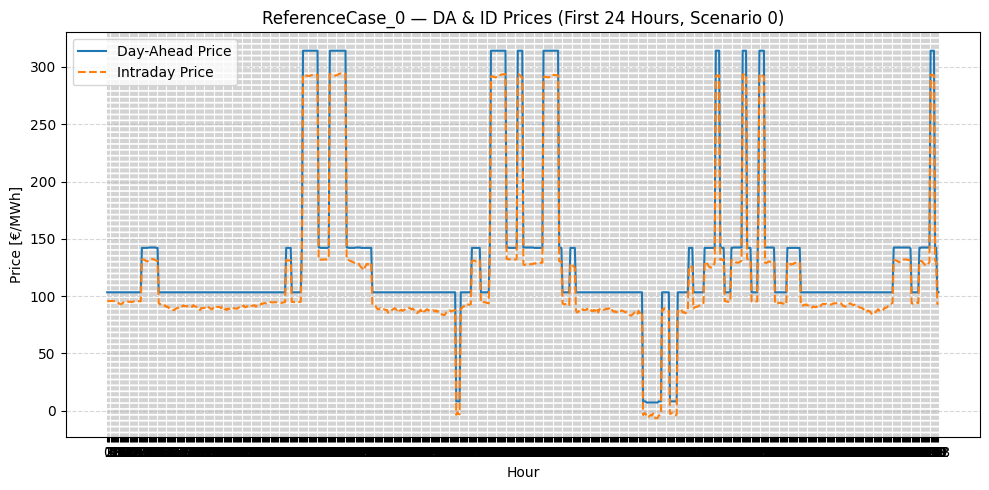

In [ ]:
import matplotlib.pyplot as plt

# Ensure the correct key
case_id = 'ReferenceCase_0'
df = DA_ID_price_frames[case_id]

# Extract 24-hour DA and ID prices for Scenario 0
da_prices = df['Scenario_0_DA'].iloc[:24*31]
id_prices = df['Scenario_0_ID'].iloc[:24*31]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(da_prices.index, da_prices.values, label='Day-Ahead Price', linestyle='-')
plt.plot(id_prices.index, id_prices.values, label='Intraday Price', linestyle='--')

# Style
plt.title('ReferenceCase_0 — DA & ID Prices (First 24 Hours, Scenario 0)')
plt.xlabel('Hour')
plt.ylabel('Price [€/MWh]')
plt.xticks(range(24*31))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


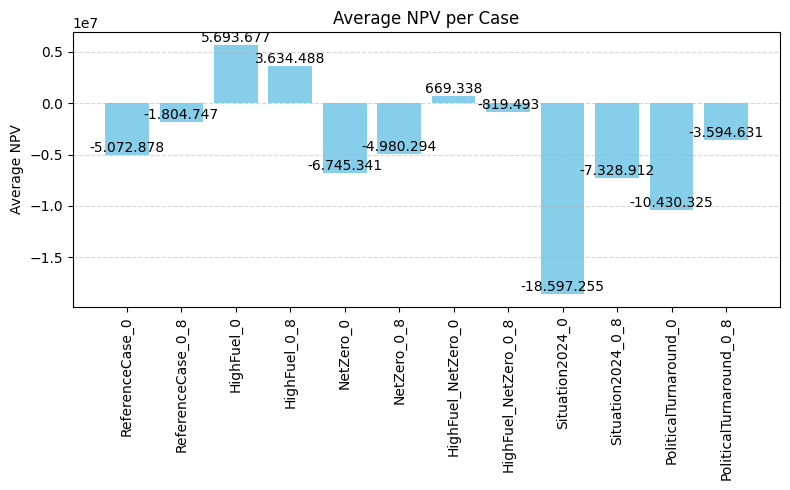

In [14]:
# Find all *_BatterySummary DataFrames and build a dictionary
battery_financial_summaries = {
    name.replace("_BatterySummary", ""): val
    for name, val in globals().items()
    if isinstance(val, pd.DataFrame) and name.endswith("_BatterySummary") and "NPV [EUR/kW]" in val.columns
}
# Calculate average NPV
avg_npv_per_case = {
    case: df["NPV [EUR/kW]"].mean()
    for case, df in battery_financial_summaries.items()
}

import matplotlib.pyplot as plt

# Format values with German-style separators
def format_number(value):
    return f"{value:,.0f}".replace(",", "X").replace(".", ",").replace("X", ".")

# Calculate average NPV
avg_npv_per_case = {
    case: df["NPV [EUR/kW]"].mean()
    for case, df in battery_financial_summaries.items()
}

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(avg_npv_per_case.keys(), avg_npv_per_case.values(), color='skyblue')

# Add data labels with separators
for bar in bars:
    yval = bar.get_height()
    label = format_number(yval)
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 10, label, ha='center', va='bottom')

plt.ylabel("Average NPV")
plt.title("Average NPV per Case")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
